# Interfacing with ML Libraries

## Overview

Machine Learning is the field of study that gives computers the
capability to learn without being explicitly programmed. Machine
learning (ML) is well known for its powerful ability to recognize
patterns and signals. Recently, the mass spectrometry community has
embraced ML techniques for large-scale data analysis.

Predicting accurate retention times (RT) has shown to improve
identification in bottom-up proteomics.

In this tutorial we will predict the RT from amino acid sequence data
using simple machine learning methods.

First, we import all necessary libraries for this tutorial.

In [ ]:
!pip install seaborn
!pip install xgboost

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter
import numpy as np
from urllib.request import urlretrieve

Once we have imported all libraries successfully, we are going to store
the dataset in a variable.

In [ ]:
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(gh + "/src/data/pyOpenMS_ML_Tutorial.tsv", "data.tsv")
tsv_data = pd.read_csv("data.tsv", sep="\t", skiprows=17)

Here, we have prepared a `tsv` file that contains three columns
`sequence`, RT and `charge`. Note that this table could also be easily
created from identification data as produced in previous chapters.

Before we move forward lets try to understand more about our data:

a\. Sequence - Chains of amino acids form peptides or proteins. The
arrangement of amino acids is referred as amino acid sequence. The
composition and order of amino acids affect the physicochemical
properties of the peptide and lead to different retention in the column.
b. Retention time (RT) - is the time taken for an analyte to pass
through a chromatography column.

From the amino acid sequence we can derive additional properties
(machine learning features) used to train our model.

We can easily check for its shape by using the tsv_data.shape attribute,
which will return the size of the dataset.

In [ ]:
print(tsv_data.shape)

``` output
(15896, 3)
```

Explore the top 5 rows of the dataset by using head() method on pandas
DataFrame.

In [ ]:
tsv_data.head()

``` output
sequence        RT          charge
0   EEETVAK             399.677766  2
1   EQEEQQQQEGHNNK      624.555300  3
2   SHGGHTVISK      625.797960  3
3   SGTHNMYK        625.982520  2
4   AARPTRPDK       626.073300  3
```

As the RT column is our response variable, we will be storing it
separately as Y1_test

In [ ]:
Y1_test = tsv_data["RT"]

## Preprocessing

Cleaning data before applying a machine learning method keeps the
relevant information in potentially massive amount of data.

Here we will apply some simple preprocessing to extract novel machine
learning features from the amino acid sequences. Some of the parameters
that can be derived are

1.  {Alphabet}\_count = The count of Amino Acids in the sequence.
2.  {Alphabet}\_freq = The count of Amino Acids divided by the total
    length of the sequence.
3.  length = The total number of amino acids in the sequence.

In [ ]:
alphabet_list = list(string.ascii_uppercase)
column_headers = (
    ["sequence"]
    + [i + "_count" for i in alphabet_list]
    + [i + "_freq" for i in alphabet_list]
    + ["charge", "length"]
)
types = (
    ["object"]
    + ["int64" for i in alphabet_list]
    + ["float64" for i in alphabet_list]
    + ["int64", "int64"]
)
pdcols = dict(zip(column_headers, types))

As we have all the column names, now we will start populating it.

In [ ]:
df = pd.DataFrame(
    np.zeros((len(tsv_data.index), len(column_headers))), columns=column_headers
)

df["sequence"] = tsv_data["sequence"]
df["charge"] = tsv_data["charge"]

# For populating the length column
df["length"] = df["sequence"].str.len()

df = df.astype(dtype=pdcols)


# For populating the {alphabet}_count columns
def count(row):
    counts = Counter(row["sequence"])
    for count in counts:
        row[count + "_count"] = int(counts[count])
    return row


df = df.apply(lambda row: count(row), axis=1)
df.head()

``` output
sequence            A_count B_count C_count D_count E_count F_count G_count H_count I_count ...     S_freq  T_freq  U_freq  V_freq  W_freq  X_freq  Y_freq  Z_freq  charge  length
0   EEETVAK             1       0       0       0       3       0       0       0       0       ...     0.0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     2       7
1   EQEEQQQQEGHNNK      0       0       0       0       4       0       1       1       0       ...     0.0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     3       14
2   SHGGHTVISK      0       0       0       0       0       0       2       2       1       ...     0.0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     3       10
3   SGTHNMYK        0       0       0       0       0       0       1       1       0       ...     0.0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     2       8
4   AARPTRPDK       2       0       0       1       0       0       0       0       0       ...     0.0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     3       9
```

Now we have completed all the data preprocessing steps. We have deduced
a good amount of information from the amino acid sequences that might
have influence on the retention time in the column.

Now we are good to proceed on building the machine learning model.

## Modelling

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit

In [ ]:
test_df = df.copy()
test_df = test_df.drop("sequence", axis=1)

Now, we create the train and test set for cross-validation of the
results using the `train_test_split` function from sklearn's
model_selection module with test_size size equal to 30% of the data. To
maintain reproducibility of the results, a random_state is also
assigned.

In [ ]:
# Splitting Test data into test and validation
X_train, X_test, Y_train, Y_test = train_test_split(
    test_df, Y1_test, test_size=0.3, random_state=3
)

We will be using the `XGBRegressor()` class because it is clearly a
regression problem as the response variable ( retention time ) is
continuous.

In [ ]:
xg_reg = XGBRegressor(
    n_estimators=300,
    random_state=3,
    max_leaves=5,
    colsample_bytree=0.7,
    max_depth=7,
)

Fit the regressor to the training set and make predictions on the test
set using the familiar `.fit()` and `.predict()` methods.

In [ ]:
xg_reg.fit(X_train, Y_train)
Y_pred = xg_reg.predict(X_test)

Compute the root mean square error (rmse) using the mean_sqaured_error
function from sklearn's metrics module.

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE: %f" % (rmse))

``` output
RMSE: 437.017290
```

Store the **Observed** v/s **Predicted** value in pandas dataframe and
print.

In [ ]:
k = pd.DataFrame(
    {"Observed": Y_test.values.flatten(), "Predicted": Y_pred.flatten()}
)
print(k)

``` output
Observed    Predicted
0           3652.28442  3927.141846
1           4244.80320  4290.294434
2           3065.19054  3703.156982
3           909.50610   762.218567
4           1982.80902  2628.958740
...         ... ...
4764    5527.23804  5599.530762
4765    3388.76430  3272.557617
4766    3101.35566  3346.364990
4767    5515.94682  5491.597168
4768    2257.63092  2258.312988
```

We will now generate a **Observed** v/s **Predicted** plot that gives a
high level overview about the model performance. We can clearly see that
only few outliers are there and most of them lie in between the central
axis. This means that prediction actually works and observed and
predicted value won't differ too much.

In [ ]:
sns.lmplot(
    x="Observed", y="Predicted", data=k, scatter_kws={"alpha": 0.2, "s": 5}
)

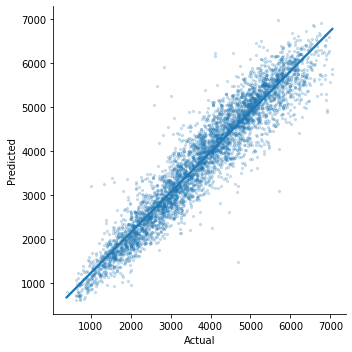

In [ ]:
p = sns.kdeplot(data=k["Observed"] - k["Predicted"], fill=True)
p.set(xlabel="Observed-Predicted (s)")

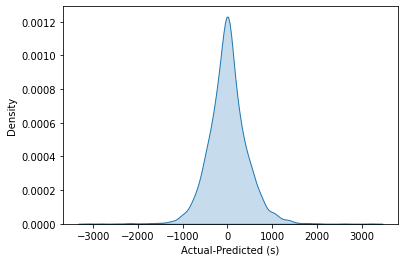

In order to build more robust models, it is common to do a k-fold cross
validation where all the entries in the original training dataset are
used for both training as well as validation. Also, each entry is used
for validation just once. XGBoost supports k-fold cross validation via
the cv() method. All we have to do is specify the nfolds parameter,
which is the number of cross validation sets we want to build.

In [ ]:
# Performing k-fold cross validation
X = np.arange(10)
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
performance_df = pd.DataFrame()
performance_list = []
counter = 0
for train_index, test_index in ss.split(X_train, Y_train):
    counter += 1

    X_train_Kfold, X_test_Kfold = (
        X_train[X_train.index.isin(train_index)].to_numpy(),
        X_train[X_train.index.isin(test_index)].to_numpy(),
    )
    y_train_Kfold, y_test_Kfold = (
        Y_train[Y_train.index.isin(train_index)].to_numpy().flatten(),
        Y_train[Y_train.index.isin(test_index)].to_numpy().flatten(),
    )

    Regressor = XGBRegressor()
    Regressor.fit(X_train_Kfold, y_train_Kfold)

    predictions = Regressor.predict(X_test_Kfold)

    df = pd.DataFrame(
        {"Observed": y_test_Kfold.flatten(), "Predicted": predictions.flatten()}
    )

    print("Fold-" + str(counter))
    print("---------------------")
    print(df)

``` output
Fold-1
---------------------
        Observed    Predicted
0     1845.17346  2051.894043
1     1155.68124  1911.122192
2     2847.94272  2753.223145
3     2370.70494  2670.160889
4     4111.31718  3961.675049
...          ...          ...
1935  3880.18458  3454.832031
1936  4125.82776  4068.806152
1937  4586.33838  3829.927002
1938  2261.99454  3225.578613
1939  4342.82430  3943.912354

[1940 rows x 2 columns]
Fold-2
---------------------
        Observed    Predicted
0     3476.56062  4075.536377
1     4009.78704  4022.654785
2     2847.94272  2779.675293
3     3669.33108  4026.944824
4     3997.12632  3566.471436
...          ...          ...
1907  2916.91818  2744.992676
1908  3569.64318  3862.661621
1909  2118.25278  2221.599854
1910  1787.61012  1839.471802
1911  3583.44846  3210.243164

[1912 rows x 2 columns]
Fold-3
---------------------
        Observed    Predicted
0     2052.18066  2237.868896
1     4336.45050  3622.901367
2     2317.39104  2496.773438
3     3356.40018  3291.187988
4     1778.73198  2034.299683
...          ...          ...
1934  3795.23424  2968.955322
1935  3622.34358  3203.385742
1936  2261.99454  3115.011475
1937  4112.62578  3743.435791
1938  4342.82430  3721.162842

[1939 rows x 2 columns]
Fold-4
---------------------
        Observed    Predicted
0     1762.89840  1691.997803
1     1292.39622  1418.658325
2     1914.00468  1779.962769
3     4571.86566  4618.782715
4     2317.39104  2417.823242
...          ...          ...
1985  2779.37664  2702.244385
1986  4335.23442  3733.191162
1987  2916.91818  2609.322021
1988  4125.82776  3947.512939
1989  3429.54294  3550.206787

[1990 rows x 2 columns]
Fold-5
---------------------
        Observed    Predicted
0     2790.00414  3010.381592
1     3476.56062  3972.215820
2     1845.17346  1901.611572
3     4009.78704  3884.857178
4     3578.05344  2993.831787
...          ...          ...
1975  3778.69704  4209.392090
1976  1494.22332  1612.613281
1977  4125.82776  3902.622559
1978  4701.03624  4372.867676
1979  1888.41552  2342.040771

[1980 rows x 2 columns]
```

That's it, we trained a simple machine learning model to predict peptide
retention times from peptide data.

Sophisticated machine models integrate retention time data from many
experiments add additional properties (or even learn them from data) of
peptides to achieve lower prediction errors.